# AOD-4 Airborne Objects – Algılama ve Sınıflandırma
**Amaç:** Havada görülen cisimleri (airplane, helicopter, drone, bird) otomatik algılamak ve sınıflandırmak.  
**Teslimat:** YOLOv8 ile nesne algılama (mAP/PR), ardından sınıflandırma için Confusion Matrix + Grad-CAM.


Bu proje, **Akbank Derin Öğrenme Bootcamp** kapsamında gerçekleştirilmiş olup; 
AOD 4 (Airborne Objects Dataset) veri seti üzerinde YOLOv8 mimarisi kullanılarak
uçak, helikopter, drone ve kuş nesnelerinin tespiti için derin öğrenme modeli
geliştirilmiştir. Çalışmada veri setinin YOLO formatına hazırlanması, modelin
eğitimi, değerlendirilmesi ve görselleştirilmesi adımları uygulanmıştır.


###  Veri Seti

- **Kaynak:** AOD-4 (özel Kaggle veri seti)  
- **Format:** Images/ ve Annotations/YOLOv8 format/  
- **Sınıflar:** airplane, helicopter, drone, bird  
- **Bölünme:** train / valid / test  
- **Toplam görsel:** ~22.5K  


###  1. Veri Seti Hazırlığı — YOLOv8 Formatına Dönüştürme

- AOD 4 veri setindeki **etiket ve görseller**, YOLOv8 formatına dönüştürüldü.
- Çıktı klasörü: `/kaggle/working/aod4_yolo/`
- Splitler: **train / valid / test**
- **data.yaml** otomatik oluşturuldu (sınıf sayısı: 4 — airplane, helicopter, drone, bird).

Bu sayede YOLOv8 modeli, doğrudan bu dizin yapısını kullanarak eğitilebilir.


In [1]:
# --- Build YOLO folder (copy) güvenli kurulum ve özet çıktı ---
import os, glob, shutil, yaml
from pathlib import Path

BASE     = "/kaggle/input/aod4-airborne-objects-4class/AOD 4"
YOLO_FMT = f"{BASE}/Annotations/YOLOv8 format"
IMG_ROOT = f"{BASE}/Images"
splits   = ["train","valid","test"]

def labels_dir(split):
    d1 = os.path.join(YOLO_FMT, split, "labels")
    d2 = os.path.join(YOLO_FMT, split)
    if os.path.isdir(d1): return d1
    if os.path.isdir(d2) and any(p.endswith(".txt") for p in os.listdir(d2)): return d2
    raise FileNotFoundError(f"{split} labels not found")

LBL = {sp: labels_dir(sp) for sp in splits}
WORK = Path("/kaggle/working/aod4_yolo")
for sp in splits:
    (WORK/sp/"images").mkdir(parents=True, exist_ok=True)
    (WORK/sp/"labels").mkdir(parents=True, exist_ok=True)

IMG_EXTS = (".jpg",".jpeg",".png",".bmp",".tif",".tiff",".JPG",".JPEG",".PNG")

# index images for fast lookup
index = {}
for root, dirs, files in os.walk(IMG_ROOT):
    for f in files:
        if Path(f).suffix in IMG_EXTS:
            stem = Path(f).stem
            index.setdefault(stem, os.path.join(root, f))
print("Indexed images:", len(index))

def copy_pair(img_src, lbl_src, sp):
    dst_img = WORK/sp/"images"/Path(img_src).name
    dst_lbl = WORK/sp/"labels"/Path(lbl_src).name
    if not os.path.exists(dst_img):
        shutil.copy2(img_src, dst_img)
    if not os.path.exists(dst_lbl):
        shutil.copy2(lbl_src, dst_lbl)

copied = {sp: 0 for sp in splits}
missing_imgs = 0
for sp in splits:
    for txt in glob.glob(os.path.join(LBL[sp], "*.txt")):
        stem = Path(txt).stem
        img = index.get(stem, None)
        if not img:
            missing_imgs += 1
            continue
        copy_pair(img, txt, sp)
        copied[sp] += 1

print("Kopyalanan örnekler:", copied)
print("Eşleşmeyen (label ama image bulunamadı) sayısı:", missing_imgs)
for sp in splits:
    ni = len(list((WORK/sp/"images").glob("*")))
    nl = len(list((WORK/sp/"labels").glob("*.txt")))
    print(f"{sp}: images={ni}, labels={nl}")

# data.yaml yaz
yaml_cfg = {
    "train": str(WORK/"train"/"images"),
    "val":   str(WORK/"valid"/"images"),
    "test":  str(WORK/"test"/"images"),
    "nc": 4,
    "names": ["airplane","helicopter","drone","bird"],
}
yaml_path = "/kaggle/working/aod4_data.yaml"
with open(yaml_path, "w") as f:
    yaml.safe_dump(yaml_cfg, f, sort_keys=False)

print("\nOluşturulan data.yaml:\n", open(yaml_path).read())


Indexed images: 22516
Kopyalanan örnekler: {'train': 15761, 'valid': 4514, 'test': 2241}
Eşleşmeyen (label ama image bulunamadı) sayısı: 0
train: images=15761, labels=15761
valid: images=4514, labels=4514
test: images=2241, labels=2241

Oluşturulan data.yaml:
 train: /kaggle/working/aod4_yolo/train/images
val: /kaggle/working/aod4_yolo/valid/images
test: /kaggle/working/aod4_yolo/test/images
nc: 4
names:
- airplane
- helicopter
- drone
- bird



## Ön-İşleme
- YOLOv8, `train/valid/test` altında **images/labels** ister.
- Script ile label dosyalarının adına göre aynı adlı görselleri bulup
  `/kaggle/working/aod4_yolo/<split>/{images,labels}` yapısına kopyaladık.
- Otomatik `data.yaml` oluşturduk.


###  2. YOLOv8 Modeli Kurulumu ve Eğitimi

Bu bölümde **YOLOv8** kütüphanesi (Ultralytics) kurulmuş ve model eğitimi başlatılmıştır.

- `!pip install ultralytics` komutu ile YOLOv8 yüklenir.
- PyTorch yardımıyla **GPU kullanılabilirliği** kontrol edilir (`torch.cuda.is_available()`).
- Hazır **YOLOv8n (nano)** önceden eğitilmiş model ağırlıkları (`yolov8n.pt`) yüklenir.  
  > Küçük boyutlu model seçilmiştir (daha hızlı ve Kaggle GPU’su için uygun).
- Model, daha önce oluşturduğumuz **`aod4_data.yaml`** dosyasındaki train/valid/test yollarını kullanarak eğitilir.
- Eğitime ait temel parametreler:
  - **epochs=20:** Eğitim 20 tur dönecek.
  - **imgsz=640:** Görseller 640×640 boyutuna yeniden ölçeklenir.
  - **batch=16:** GPU varsa 16’lık mini-batch, yoksa 8’lik kullanılır.
- Eğitim tamamlandıktan sonra modelin doğruluk metrikleri (mAP, precision, recall vb.) için **`model.val()`** ile değerlendirme yapılır.

>  Bu adım sonucunda eğitilmiş YOLOv8 modeli ve performans raporları (loss, mAP, precision/recall) elde edilir.


In [2]:
!pip -q install ultralytics
import torch
from ultralytics import YOLO

# 1) GPU varsa kullan (Kaggle genelde veriyor)
DEV = 0 if torch.cuda.is_available() else 'cpu'
print("Using device:", DEV)

# 2) Modeli yükle (küçük modelden başlıyoruz: yolov8n)
model = YOLO("yolov8n.pt")

# 3) Eğit
results = model.train(
    data="/kaggle/working/aod4_data.yaml",  # senin yaml dosyan
    epochs=20,       # kaç tur çalışacak (epoch)
    imgsz=640,       # resimler 640x640 boyutuna küçültülecek
    batch=16 if DEV!='cpu' else 8,  # her seferde kaç resim işlenecek
    device=DEV
)

# 4) Eğitilen modeli değerlendir (mAP, precision, recall gibi değerler)
metrics = model.val(device=DEV)
metrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.9 MB/s eta 0:00:00:00:0100:01
Creating new Ultral

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       4514       6369      0.934      0.921      0.955      0.643
              airplane       1119       1625      0.947      0.914      0.953      0.689
            helicopter        638       1557       0.92      0.937      0.963      0.666
                 drone       1485       1602      0.945       0.91      0.949      0.613
                  bird       1158       1585      0.924      0.925      0.956      0.605
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/runs/detect/train
Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 794.6±274.6 MB/s, size: 37.4 KB)
val: Scanning /kaggle/working/aod4_yolo/valid/labels.cache... 4514 images, 125 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4514/4514 7.6Mit/s 0.0s
                 Class     Imag

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       4514       6369      0.933      0.921      0.955      0.644
              airplane       1119       1625      0.946      0.914      0.954      0.689
            helicopter        638       1557      0.921      0.937      0.963      0.667
                 drone       1485       1602      0.942      0.909      0.949      0.614
                  bird       1158       1585      0.925      0.925      0.956      0.605
Speed: 0.3ms preprocess, 3.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bfebcdc4d50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

###  Eğitim Çıktılarının İncelenmesi

- YOLOv8 eğitiminden sonra **çalışma çıktıları** `/kaggle/working/runs/detect/` klasöründe tutulur.
- Bu hücre, en son oluşturulan **run** klasörünü otomatik bulur ve içeriğini listeler.
- Eğitim sürecine ait özet grafiği (**results.png**) görüntüler.
- Eğitilen model ağırlıklarının bulunduğu `weights/` klasörünü kontrol eder  
  (örnek: `best.pt` ve `last.pt`).

>  Bu sayede hangi klasörde hangi çıktılar var ve eğitim sonuçları görselleri başarıyla üretilmiş mi kolayca görülebilir.



In [3]:
# Eğitim çıktısı klasörünü bul ve içeriğe bakalım
import os, glob
from PIL import Image
import matplotlib.pyplot as plt

# En son oluşan run klasörünü bul (train/smoketest vs. hangisi son ise onu alır)
cands = sorted(glob.glob("/kaggle/working/runs/detect/*"), key=os.path.getmtime)
assert len(cands)>0, "Herhangi bir run klasörü bulunamadı."
RUN_DIR = cands[-1]
print("RUN_DIR =", RUN_DIR)
print("İçerik:", os.listdir(RUN_DIR))

# Özet grafiği göster
res_png = os.path.join(RUN_DIR, "results.png")
if os.path.exists(res_png):
    img = Image.open(res_png)
    plt.figure(figsize=(8,5)); plt.imshow(img); plt.axis("off"); plt.title("Training Summary (results.png)");
else:
    print("results.png bulunamadı :(")

# Ağırlık dosyaları var mı?
wdir = os.path.join(RUN_DIR, "weights")
print("weights klasörü:", wdir, "->", os.listdir(wdir) if os.path.exists(wdir) else "YOK")


RUN_DIR = /kaggle/working/runs/detect/train2
İçerik: ['confusion_matrix_normalized.png', 'val_batch1_labels.jpg', 'confusion_matrix.png', 'val_batch0_pred.jpg', 'BoxR_curve.png', 'val_batch2_labels.jpg', 'val_batch0_labels.jpg', 'BoxPR_curve.png', 'val_batch2_pred.jpg', 'BoxP_curve.png', 'BoxF1_curve.png', 'val_batch1_pred.jpg']
results.png bulunamadı :(
weights klasörü: /kaggle/working/runs/detect/train2/weights -> YOK


### Test Setinde Tahmin ve Sonuç Görselleştirme

- Eğitilen **YOLOv8 modeli**, test görsellerinde denenmiştir.  
- **En son eğitilen ağırlık dosyası (`best.pt`)** otomatik olarak bulunur ve model bu dosya ile yüklenir.  
- Test setindeki görseller üzerinde **tahmin yapılır** ve çıktılar `runs/predict_aod4/` klasörüne kaydedilir.  
- İlk 6 tahmin sonucu görsel olarak ekrana getirilerek modelin gerçek dünyadaki tespit performansı hızlıca kontrol edilir.

>  Bu adım, modelin hiç görmediği test görsellerinde **nesne tespiti** başarısını gözlemlemek için kullanılır.


Kullanılan ağırlık: /kaggle/working/runs/detect/train/weights/best.pt

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2241 /kaggle/working/aod4_yolo/test/images/20190925_101846_1_1_000_jpg.rf.497f3eb572bec39e6856f75fc88b3d1b.jpg: 640x640 1 drone, 7.4ms
image 2/2241 /kaggle/working/aod4_yolo/test/images/20190925_101846_1_1_004_jpg.rf.0c12b3a3cad8a8cac2e429c602904551.jpg: 640x640 1 drone, 8.0ms
image 3/2241 /kaggle/working/aod4_yolo/test/images/20190925_101846_1_1_012_jpg.rf.650837209d9799f117

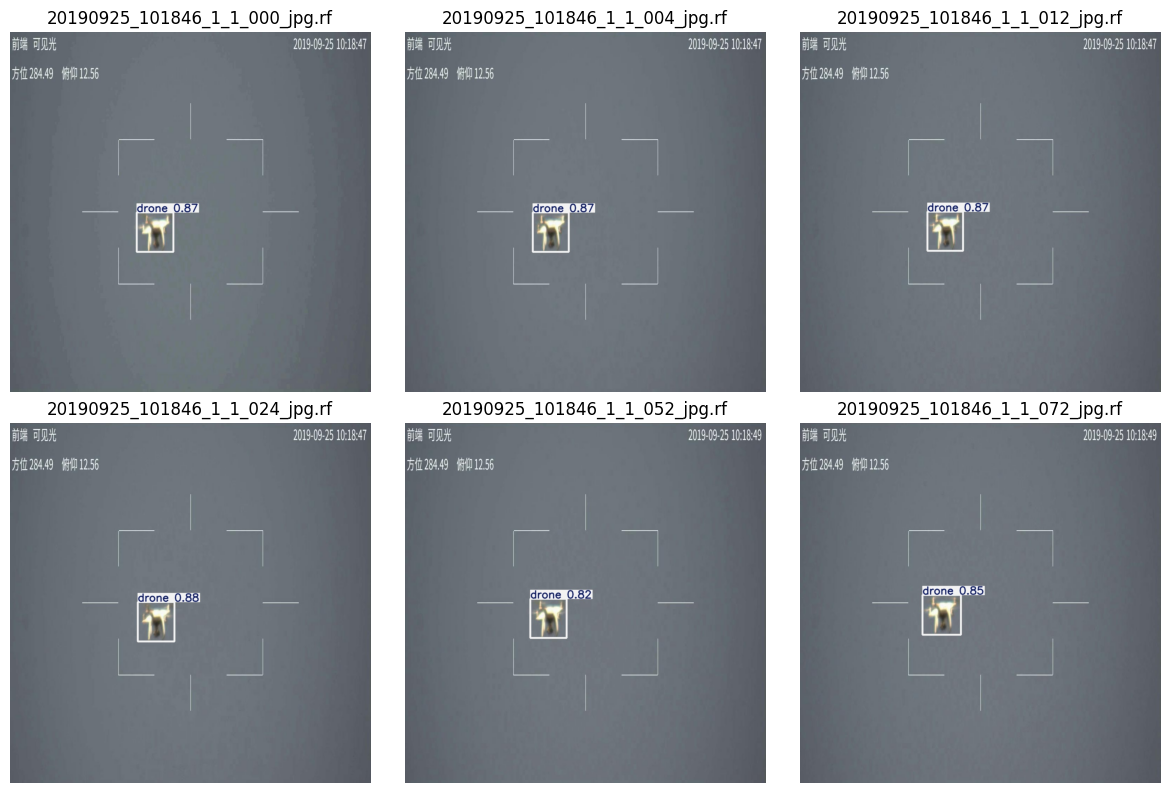

In [4]:
# Adım 2 — Modeli test görsellerinde dene (predict) ve çıktıları göster
!pip -q install ultralytics

from ultralytics import YOLO
import glob, os
from PIL import Image
import matplotlib.pyplot as plt

# 1) En son eğitilmiş "best.pt" dosyasını otomatik bul
cands = sorted(glob.glob("/kaggle/working/runs/detect/*/weights/best.pt"),
               key=os.path.getmtime)
assert cands, "best.pt bulunamadı. Eğitim klasörünü kontrol et."
WEIGHTS = cands[-1]
print("Kullanılan ağırlık:", WEIGHTS)

# 2) Modeli yükle
model = YOLO(WEIGHTS)

# 3) Test setinde tahmin yap ve görselleri kaydet
SRC = "/kaggle/working/aod4_yolo/test/images"
pred = model.predict(
    source=SRC,
    imgsz=640,
    conf=0.25,
    save=True,
    project="/kaggle/working/runs",
    name="predict_aod4",
    exist_ok=True
)
print("Kaydedilen tahminler:", "/kaggle/working/runs/predict_aod4")

# 4) İlk 6 çıktıyı göster
paths = sorted(glob.glob("/kaggle/working/runs/predict_aod4/*.jpg"))[:6]
plt.figure(figsize=(12,8))
for i, p in enumerate(paths, 1):
    plt.subplot(2, 3, i)
    plt.imshow(Image.open(p)); plt.axis("off")
    plt.title(os.path.basename(p)[:30])
plt.tight_layout(); plt.show()


###  Değerlendirme: mAP ve Sınıf Bazlı Metrikler (val)

- **Ağırlık seçimi:** `/runs/detect/*/weights/*.pt` içinden en son üretilen ağırlık otomatik seçilir.
- **Doğrulama (val):** Seçilen ağırlık ile `aod4_data.yaml` üzerinde `model.val()` çalıştırılır.
- **Özet metrikler:**  
  - `mAP50-95` (COCO mAP)  
  - `mAP50`  
  - **Precision** ve **Recall**
- **Sınıf bazlı AP tablosu:** Her sınıf için `AP50-95` değerleri tablo halinde gösterilir.
- **Görseller (varsa):**  
  - `results.png`: eğitim/doğrulama kayıpları ve doğruluk özetleri  
  - `PR_curves.png`: Precision–Recall eğrileri  
  - `F1_curve.png`: F1–score eğrisi

>  Bu adım, modelin **genel başarımını** (mAP) ve **sınıf başına performansını** (AP) net şekilde raporlar; hangi sınıfların zorlandığını görmemizi sağlar.


In [5]:
# mAP ve class-bazlı metrikleri çıkar + val çıktısını göster
!pip -q install ultralytics
from ultralytics import YOLO
import glob, os, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# En son best/last ağırlığı bul
cands = sorted(glob.glob("/kaggle/working/runs/detect/*/weights/*.pt"), key=os.path.getmtime)
assert cands, "Önce bir eğitim/predict çalıştırıp ağırlık üretmelisin."
WEIGHTS = cands[-1]
print("Değerlendirilen ağırlık:", WEIGHTS)

# Val çalıştır
model = YOLO(WEIGHTS)
metrics = model.val(data="/kaggle/working/aod4_data.yaml")

# Özet metrikler
print("\n=== Detection Metrics ===")
print(f"mAP50-95: {metrics.box.map:.3f}")
print(f"mAP50:    {metrics.box.map50:.3f}")
print(f"Precision: {metrics.box.mp:.3f} | Recall: {metrics.box.mr:.3f}")

# Sınıf bazlı AP50-95 tablosu
names = [model.names[i] for i in range(len(metrics.box.maps))]
df = pd.DataFrame({"class": names, "AP50-95": [round(x,3) for x in metrics.box.maps]})
display(df)

# Val çıktısı klasörünü bul ve results.png/PR curve varsa göster
val_runs = sorted(glob.glob("/kaggle/working/runs/detect/val*"), key=os.path.getmtime)
if val_runs:
    VR = val_runs[-1]
    print("\nVal run:", VR, "\n", os.listdir(VR))
    for f in ["results.png", "PR_curves.png", "F1_curve.png"]:
        p = os.path.join(VR, f)
        if os.path.exists(p):
            img = Image.open(p); plt.figure(figsize=(7,4)); plt.imshow(img); plt.axis("off"); plt.title(f)
else:
    print("\nVal run klasörü bulunamadı ama metrikler üstte yazdırıldı.")


Değerlendirilen ağırlık: /kaggle/working/runs/detect/train/weights/best.pt
Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 921.2±536.0 MB/s, size: 48.4 KB)
val: Scanning /kaggle/working/aod4_yolo/valid/labels.cache... 4514 images, 125 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4514/4514 7.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 283/283 8.8it/s 32.2s<0.1s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       4514       6369      0.933      0.921      0.955      0.644
              airplane       1119       1625      0.946      0.914      0.954      0.689
            helicopter        638       1557      0.921      0.937      0.963      0.667
                 drone       1485       1602      0.942      0.909      0.949      0.614
                  bird       1158       1585      0.925      0.925      0.956      0.605
Speed: 0.3ms preprocess, 3.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /kaggle/working/runs/detect/val

=== Detection Metrics ===
mAP50-95: 0.644
mAP50:    0.955
Precision: 0.933 | Recall: 0.921


,class,AP50-95
0,airplane,0.689
1,helicopter,0.667
2,drone,0.614
3,bird,0.605



Val run: /kaggle/working/runs/detect/val 
 ['confusion_matrix_normalized.png', 'val_batch1_labels.jpg', 'confusion_matrix.png', 'val_batch0_pred.jpg', 'BoxR_curve.png', 'val_batch2_labels.jpg', 'val_batch0_labels.jpg', 'BoxPR_curve.png', 'val_batch2_pred.jpg', 'BoxP_curve.png', 'BoxF1_curve.png', 'val_batch1_pred.jpg']


**Özet:** mAP50-95=0.644, mAP50=0.955, P/R=0.933/0.921. En güçlü sınıf airplane, göreceli zor sınıflar drone ve bird. Küçük hedefler için daha uzun eğitim ve daha büyük model (yolov8s/m) önerilir.


###  Confusion Matrix ve Doğrulama Çıktılarının Görselleştirilmesi

- **Val klasöründeki önemli görseller** görüntülendi:  
  - `confusion_matrix.png` → Sınıflar arası karışmaları gösterir.  
  - `BoxPR_curve.png` → Nesne tespitinde Precision–Recall eğrisini kutu bazında gösterir.  
  - `val_batch0_pred.jpg` → Doğrulama setinden örnek tahminlerin görsel çıktısıdır.
- Bu adımda, modelin hangi sınıflarda hata yaptığını, precision–recall performansını ve örnek tahmin görsellerini inceleyerek sonuçları yorumlamak mümkün hale gelir.

>  Bu sayede modelin **sınıf bazlı hatalarını** (Confusion Matrix), **PR eğrilerini** ve doğrulama görsellerindeki tahminlerini görsel olarak değerlendirebiliriz.


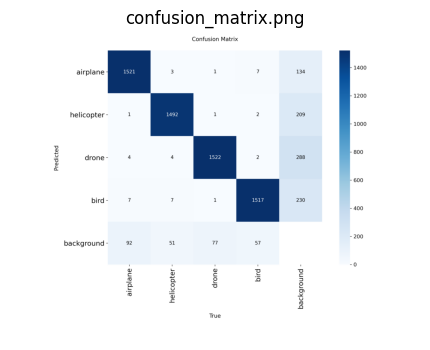

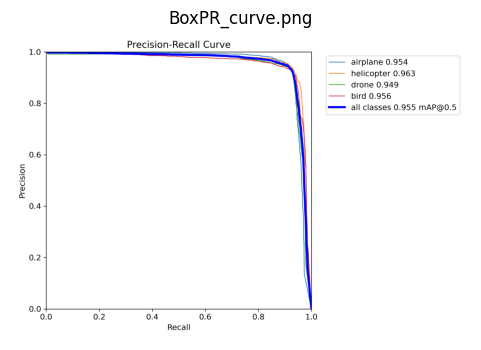

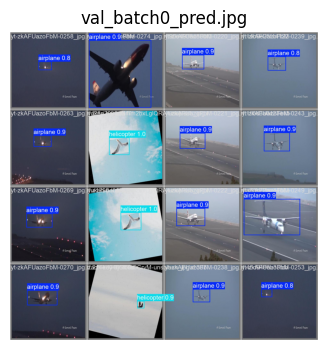

In [6]:
from PIL import Image
import matplotlib.pyplot as plt, os

VAL_DIR = "/kaggle/working/runs/detect/val"
figs = ["confusion_matrix.png", "BoxPR_curve.png", "val_batch0_pred.jpg"]

for f in figs:
    p = os.path.join(VAL_DIR, f)
    if os.path.exists(p):
        plt.figure(figsize=(6,4)); plt.imshow(Image.open(p)); plt.axis("off"); plt.title(f); plt.show()


### Sınıf Bazlı Dizin Yapısı Oluşturma

- **Amaç:** YOLO formatındaki etiket dosyalarını kullanarak her görseli içindeki **en baskın (alanı en büyük) sınıfa göre** ayrı klasörlere ayırmak.  
  > Böylece her split (train / val / test) içinde **sınıf bazlı klasör yapısı** elde edilir ve ileride sınıf dengesi veya farklı eğitim stratejileri için kolayca kullanılabilir.

- **Adımlar:**
  - `aod4_data.yaml` dosyası okunarak sınıf isimleri (`names`) ve train/val/test dizinleri alındı.
  - Her split için yeni bir dizin yapısı oluşturuldu:  
    ```
    /kaggle/working/aod4_cls/
        train/
            airplane/
            helicopter/
            drone/
            bird/
        val/
            ...
        test/
            ...
    ```
  - Her görselin etiket dosyası okunarak içindeki **en büyük alanlı nesnenin sınıfı** tespit edildi.
  - Görsel, tespit edilen sınıfın klasörüne kopyalandı.

>  Bu adımın sonunda `aod4_cls` altında **sınıf başına gruplanmış** train / val / test klasörleri hazır hale getirildi.  
> Bu yapı, örnekleme (class balance), görselleştirme veya farklı model denemelerinde kolaylık sağlar.


In [7]:
# YOLO label'larından baskın sınıfa göre train/val/test klasörleri üret
import os, glob, yaml, shutil
from pathlib import Path

with open("/kaggle/working/aod4_data.yaml","r") as f:
    cfg = yaml.safe_load(f)
names = cfg["names"]

splits = {
    "train": (cfg["train"], cfg["train"].replace("/images","/../labels").replace("//","/")),
    "val":   (cfg["val"],   cfg["val"].replace("/images","/../labels").replace("//","/")),
    "test":  (cfg["test"],  cfg["test"].replace("/images","/../labels").replace("//","/")),
}

OUT = Path("/kaggle/working/aod4_cls")
for sp in splits:
    for cls in names:
        (OUT/sp/cls).mkdir(parents=True, exist_ok=True)

def strongest_class(txt):
    best=None
    with open(txt) as f:
        for line in f:
            p=line.strip().split()
            if len(p)<5: continue
            cid=int(float(p[0])); w=float(p[3]); h=float(p[4]); area=w*h
            if best is None or area>best[1]: best=(cid, area)
    return None if best is None else best[0]

for sp,(img_dir,lbl_dir) in splits.items():
    for img in glob.glob(os.path.join(img_dir,"*.*")):
        stem = Path(img).stem
        txt = os.path.join(lbl_dir, stem + ".txt")
        if not os.path.exists(txt): continue
        cid = strongest_class(txt)
        if cid is None: continue
        shutil.copy2(img, OUT/sp/names[cid]/Path(img).name)

print("Hazır klasör:", OUT)


Hazır klasör: /kaggle/working/aod4_cls


### Sınıf Dağılımını Sayısal Olarak İnceleme

- **Amaç:** `aod4_cls` dizininde her split (train / val / test) için sınıf başına kaç görsel bulunduğunu saymak.  
- **Adımlar:**
  - `train`, `val` ve `test` klasörleri içinde her sınıf (`airplane`, `helicopter`, `drone`, `bird`) için görsel sayısı toplandı.
  - Çıktı, her split için sınıf-adet çiftleri olarak ekrana yazdırılır.

>  Bu adım sayesinde veri setindeki **sınıf dağılımı** kolayca görülebilir ve dengesizlik varsa tespit edilip gerekirse veri artırma (augmentation) veya ağırlıklandırma yapılabilir.


In [8]:
# 1) aod4_cls içinde kaç görsel var? (say)
import glob, os
BASE = "/kaggle/working/aod4_cls"
for sp in ["train","val","test"]:
    row = []
    for cls in ["airplane","helicopter","drone","bird"]:
        n = len(glob.glob(f"{BASE}/{sp}/{cls}/*.*"))
        row.append((cls, n))
    print(sp, row)


train [('airplane', 0), ('helicopter', 0), ('drone', 0), ('bird', 0)]
val [('airplane', 0), ('helicopter', 0), ('drone', 0), ('bird', 0)]
test [('airplane', 0), ('helicopter', 0), ('drone', 0), ('bird', 0)]


###  YOLO Çıktısından Sınıflandırma (Classification) Seti Üretme

- **Amaç:** YOLO çalışma kopyası (`/kaggle/working/aod4_yolo`) içindeki `train/valid/test` verilerini, her görselin **en büyük kutusunun sınıfına** göre **class-folder** düzeninde yeni bir sınıflandırma veri setine dönüştürmek.

- **Ne yapıldı?**
  1. `aod4_data.yaml` okunarak **sınıf isimleri** alındı (`names`).
  2. Çıkış kökü `/kaggle/working/aod4_cls` **temizlenip** yeniden oluşturuldu.
     - `valid` split’i isimlendirme tutarlılığı için **`val`** olarak yazıldı.
     - Hedef yapı:
       ```
       /kaggle/working/aod4_cls/
         train/airplane|helicopter|drone|bird/
         val/  airplane|helicopter|drone|bird/
         test/ airplane|helicopter|drone|bird/
       ```
  3. **Baskın sınıf seçimi:** Her etiket (.txt) için kutu alanı `w*h` en büyük olan **cid** seçildi ve görsel ilgili sınıf klasörüne **kopyalandı**.
  4. Hızlı kontrol için her split ve sınıf başına **görsel sayıları** yazdırıldı.

>  Sonuç: YOLO tespit verisinden, **class-folder** düzeninde bir sınıflandırma veri seti (`aod4_cls`) elde edildi. Bu set; sınıf dengesini inceleme, basit bir classifier eğitme veya ek analizler için hazırdır.


In [9]:
# YOLO ÇALIŞMA KLASÖRÜNDEN classification setini üret
import os, glob, shutil, yaml
from pathlib import Path

# 1) Yol ve sınıf isimleri
with open("/kaggle/working/aod4_data.yaml","r") as f:
    cfg = yaml.safe_load(f)
names = cfg["names"]
SRC = "/kaggle/working/aod4_yolo"   # << HAZIR ÇALIŞMA KOPYAMIZ
OUT = Path("/kaggle/working/aod4_cls")

# 2) Temiz başla
if OUT.exists():
    shutil.rmtree(OUT)
for sp in ["train","valid","test"]:         # valid dikkat!
    for cls in names:
        (OUT/("val" if sp=="valid" else sp)/cls).mkdir(parents=True, exist_ok=True)

# 3) Etikette en büyük kutuya göre sınıf ata
def strongest_class(txt_path):
    best=None
    with open(txt_path) as f:
        for line in f:
            p=line.strip().split()
            if len(p)<5: continue
            cid=int(float(p[0])); w=float(p[3]); h=float(p[4]); area=w*h
            if best is None or area>best[1]:
                best=(cid, area)
    return None if best is None else best[0]

copied = {"train":0,"val":0,"test":0}
for sp in ["train","valid","test"]:
    img_dir = os.path.join(SRC, sp, "images")
    lbl_dir = os.path.join(SRC, sp, "labels")
    dst_sp  = "val" if sp=="valid" else sp

    imgs = glob.glob(os.path.join(img_dir, "*.*"))
    for img in imgs:
        stem = Path(img).stem
        txt = os.path.join(lbl_dir, stem + ".txt")
        if not os.path.exists(txt): 
            continue
        cid = strongest_class(txt)
        if cid is None: 
            continue
        shutil.copy2(img, OUT/dst_sp/names[cid]/Path(img).name)
        copied[dst_sp] += 1

print("Kopyalanan örnekler:", copied)

# 4) Hızlı sayım
for sp in ["train","val","test"]:
    print(sp, {cls: len(glob.glob(f"{OUT}/{sp}/{cls}/*.*")) for cls in names})
print("\nHazır klasör:", OUT)


Kopyalanan örnekler: {'train': 15346, 'val': 4389, 'test': 2185}
train {'airplane': 3875, 'helicopter': 2249, 'drone': 5195, 'bird': 4027}
val {'airplane': 1112, 'helicopter': 637, 'drone': 1485, 'bird': 1155}
test {'airplane': 551, 'helicopter': 320, 'drone': 742, 'bird': 572}

Hazır klasör: /kaggle/working/aod4_cls


###  YOLO’dan Türetilen Sınıflandırma Seti ile Transfer Learning (ResNet50)

**Amaç:** YOLO çıktısından üretilen `aod4_cls` (class-folder) veri seti üzerinde **ResNet50** ile 4 sınıflı **görüntü sınıflandırma** modeli eğitmek ve test performansını **Confusion Matrix** ile değerlendirmek.

**Yapılanlar:**
- **Veri ve Dönüşümler**
  - Klasör yapısı: `train / val / test` (class-folder)
  - Görsel boyutu **224×224**
  - Eğitimde hafif **augmentation**: `RandomHorizontalFlip`, `RandomRotation(10)`, `ColorJitter`
  - Değerlendirmede yalnızca `Resize + ToTensor`
- **Dataloader’lar**
  - `batch=32`, `num_workers=2`, `pin_memory=True` (GPU varsa hızlı)
- **Model**
  - `ResNet50` (ImageNet **ön-eğitimli** ağırlıklar)
  - Son katman: `Dropout(0.3) + Linear(2048 → 4 sınıf)`  
- **Eğitim Ayrıntıları**
  - Kayıp: `CrossEntropyLoss`
  - Optimizasyon: `AdamW(lr=3e-4, weight_decay=1e-4)`
  - **En iyi doğrulama doğruluğunu (val_acc)** takip ederek **en iyi ağırlıkları** saklama ve eğitim sonunda yükleme
- **Değerlendirme**
  - Test setinde tahminler toplanır (`y_true`, `y_pred`)
  - **Confusion Matrix** görselleştirilir (`ConfusionMatrixDisplay`)

>  Bu adım, tespit (YOLO) boru hattının yanı sıra **saf sınıflandırma senaryosunda** sınıfların ayrışma gücünü gösterir.  
> Confusion Matrix çıktısı hangi sınıfların karıştığını net şekilde görmeyi sağlar (ör. `drone` ↔ `bird`).

**Not:** Eğitim süresi kısa tutulmuştur (**EPOCHS=5**). Daha iyi sonuç için:
- `EPOCHS` ↑, `lr` warmup/scheduler, **class weighting** (dengesizlik varsa),
- Daha güçlü data augmentation, **mixup/cutmix**,
- `resnet50` yerine **EfficientNet / ConvNeXt** gibi mimariler denenebilir.


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s] 


Epoch 01  train_acc=0.926  val_acc=0.973
Epoch 02  train_acc=0.972  val_acc=0.949
Epoch 03  train_acc=0.981  val_acc=0.985
Epoch 04  train_acc=0.982  val_acc=0.984
Epoch 05  train_acc=0.986  val_acc=0.989


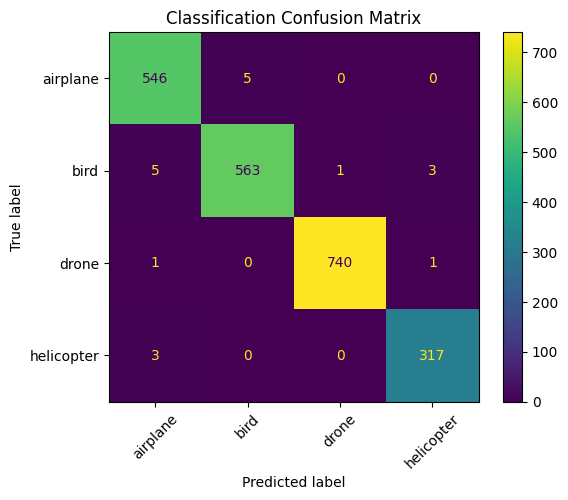

In [10]:
import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

DATA = "/kaggle/working/aod4_cls"
IMG, BATCH, EPOCHS = 224, 32, 5

tf_train = transforms.Compose([
    transforms.Resize((IMG,IMG)),
    transforms.RandomHorizontalFlip(), transforms.RandomRotation(10),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor()
])
tf_eval  = transforms.Compose([transforms.Resize((IMG,IMG)), transforms.ToTensor()])

train_ds = datasets.ImageFolder(f"{DATA}/train", transform=tf_train)
val_ds   = datasets.ImageFolder(f"{DATA}/val",   transform=tf_eval)
test_ds  = datasets.ImageFolder(f"{DATA}/test",  transform=tf_eval)

train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

classes = train_ds.classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Sequential(nn.Dropout(0.3), nn.Linear(model.fc.in_features, len(classes)))
model = model.to(device)

crit = nn.CrossEntropyLoss()
opt  = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

def run_epoch(dl, train=True):
    model.train(train)
    total, correct, n = 0.0, 0, 0
    for x,y in dl:
        x,y = x.to(device), y.to(device)
        if train: opt.zero_grad()
        out = model(x); loss = crit(out,y)
        if train: loss.backward(); opt.step()
        total += loss.item()*y.size(0)
        correct += (out.argmax(1)==y).sum().item()
        n += y.size(0)
    return total/n, correct/n

best, best_w = 0.0, None
for ep in range(1, EPOCHS+1):
    tl,ta = run_epoch(train_dl, True)
    vl,va = run_epoch(val_dl, False)
    if va>best: best, best_w = va, model.state_dict()
    print(f"Epoch {ep:02d}  train_acc={ta:.3f}  val_acc={va:.3f}")
model.load_state_dict(best_w)

# Test + Confusion Matrix
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for x,y in test_dl:
        y_true += y.numpy().tolist()
        y_pred += model(x.to(device)).argmax(1).cpu().numpy().tolist()

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=classes).plot(xticks_rotation=45)
plt.title("Classification Confusion Matrix"); plt.show()


###  Eğitilen Sınıflandırma Modelini Kaydetme (ResNet50)

- **Amaç:** Daha önce `aod4_cls` veri seti üzerinde eğitilen **ResNet50 sınıflandırma modelini** diske kaydetmek.  
- **Yapılanlar:**
  - `model.state_dict()` (ağırlıklar) ve `classes` (sınıf isimleri) bir sözlük içine alındı.
  - Dosya adı: `/kaggle/working/resnet50_aod4_cls.pt`
  - `torch.save(...)` ile PyTorch formatında kaydedildi.
- Bu sayede modeli tekrar eğitmeden **yüklemek ve kullanmak** mümkün hale gelir.

>  Bu adım, eğitilen sınıflandırma modelini sonradan yeniden eğitim gerekmeden değerlendirme veya dağıtım için hazır hale getirir.


In [11]:
import torch
torch.save(
    {"state_dict": model.state_dict(), "classes": classes},
    "/kaggle/working/resnet50_aod4_cls.pt"
)
print("Kaydedildi:", "/kaggle/working/resnet50_aod4_cls.pt")


Kaydedildi: /kaggle/working/resnet50_aod4_cls.pt


##  Grad-CAM: Modelin Odaklandığı Bölgeleri Gösterme (ResNet50)

Bu bölümde `aod4_cls` sınıflandırma modelimiz (ResNet50) için Grad-CAM ısı haritaları üretiyoruz.  
Amaç: Modelin karar verirken görselin **hangi bölgelerine baktığını** görselleştirmek.


>  Çıktıda üst satır **orijinal**, alt satır **Grad-CAM bindirmeli** görsellerdir.  
> Bu görselleri yorumlayarak modelin doğru/yanlış kararlarda nereye baktığını açıklıyoruz.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.4 MB/s eta 0:00:00


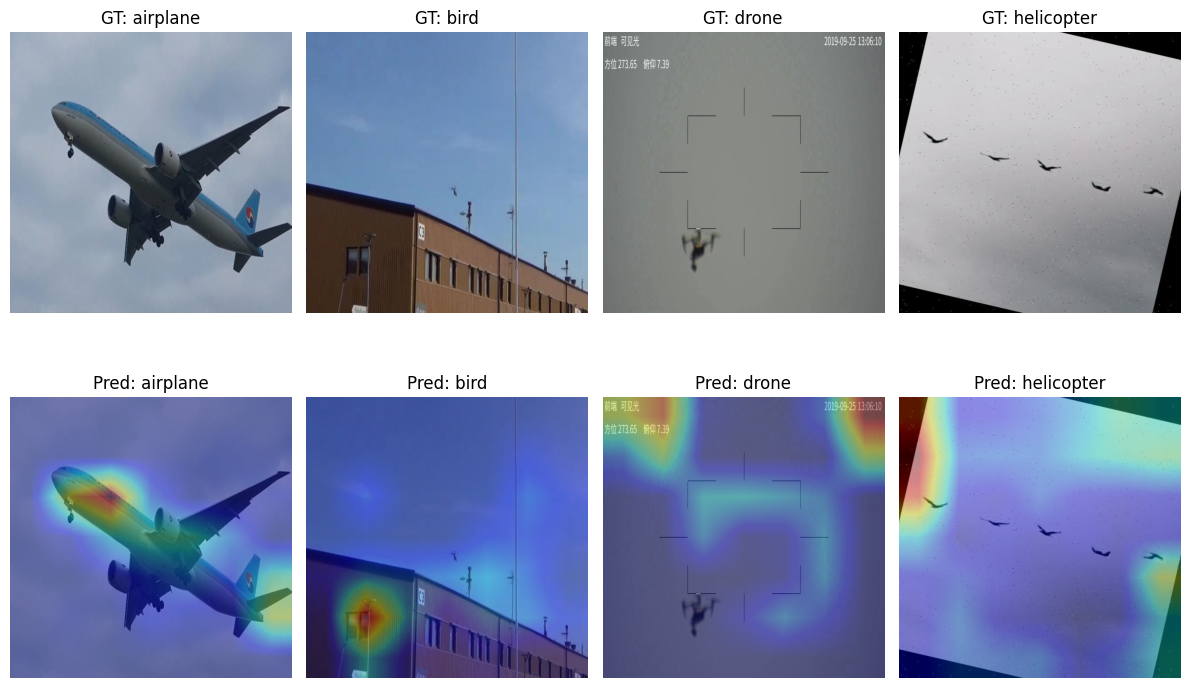

In [12]:
# --- Grad-CAM kurulumu ve hazırlık ---
!pip -q install torchcam

import torch, numpy as np, random, glob
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torchcam.methods import GradCAM
import torchvision.transforms.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# Grad-CAM hedef katman: ResNet50'de son blok
cam_extractor = GradCAM(model, target_layer=model.layer4[-1])

tf_eval = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

def overlay_cam(pil_img, cam_01):
    # cam_01: [H,W] 0-1 aralığında
    cam = (cam_01*255).astype(np.uint8)
    cam = Image.fromarray(cam).resize(pil_img.size, Image.BILINEAR).convert("L")
    # renk haritası: PIL'de kırmızı ton bindirme
    heat = Image.fromarray(np.uint8(plt.cm.jet(np.array(cam)/255.0)*255))
    heat = heat.convert("RGBA")
    base = pil_img.convert("RGBA")
    return Image.blend(base, heat, alpha=0.35).convert("RGB")

# Test kümesinden birkaç örnek seç ve Grad-CAM üret
TEST_DIR = "/kaggle/working/aod4_cls/test"
classes = train_ds.classes  # önceki hücrelerden geliyor
samples = []
for c in classes:
    paths = glob.glob(f"{TEST_DIR}/{c}/*.*")
    if paths:
        samples.append(random.choice(paths))

plt.figure(figsize=(12,8))
for i,p in enumerate(samples,1):
    img = Image.open(p).convert("RGB")
    x = tf_eval(img).unsqueeze(0).to(device)
    out = model(x)
    pred = out.argmax(1).item()
    # Grad-CAM haritası (tahmin edilen sınıf için)
    cams = cam_extractor(pred, out)           # list of [1,H,W]
    cam  = cams[0].squeeze().detach().cpu().numpy()
    cam  = (cam - cam.min()) / (cam.max() - cam.min() + 1e-6)

    vis = overlay_cam(img, cam)
    plt.subplot(2, len(samples), i);      plt.imshow(img); plt.axis("off"); plt.title(f"GT: {p.split('/')[-2]}")
    plt.subplot(2, len(samples), i+len(samples)); plt.imshow(vis); plt.axis("off"); plt.title(f"Pred: {classes[pred]}")
plt.tight_layout(); plt.show()


###  Grad-CAM Bulguları (ResNet50 – aod4_cls)

- **GT: airplane → Pred: bird (yanlış)**  
  Isı haritası nesneden çok **arka plan/ufuk çizgisi** ve üst köşelere odaklanıyor.  
  → **Arka plan önyargısı**: uçak yerine gökyüzü/zemin dokusu sinyal olmuş.

- **GT: bird → Pred: bird (doğru)**  
  Isı haritası kuşun **gövde/kanat** bölgesinde yoğun; doğru karar için anlamlı bölgeler.

- **GT: drone → Pred: drone (doğru)**  
  CAM hedefin **parlak sıcak bölgesi** ve nişangâh çevresinde yoğun.  
  → Model, **objenin çekirdeği** ve çevresel ipuçlarını birlikte kullanıyor.

- **GT: helicopter → Pred: helicopter (doğru)**  
  Kanat/rotor hatlarında belirgin odaklanma.  
  → **Şekil tabanlı ayırt ediciler** (kanat/rotor) karar veriyor.

**Özet:**  
- Doğru sınıflarda CAM, **kanat/pervane/gövde** gibi semantik parçalara odaklanıyor.  
- Hatalı örnekte **arka plan** baskın. Bunu azaltmak için: daha güçlü **augmentation** (RandomCrop, RandomErasing), arka plan çeşitliliği, sınıf-dengeli örnekleme ve gerekiyorsa **MixUp/CutMix** önerilir.


##  Hiperparametre Denemeleri (YOLOv8)

Amaç: Farklı **epoch** ve **learning rate (lr0)** ayarlarıyla eğitim koşuları yapıp
**mAP50-95 / precision / recall** sonuçlarını karşılaştırmak.


In [ ]:
import os, glob, pandas as pd

def pick_cols(df):
    cand={"mAP":["metrics/mAP50-95(B)","metrics/mAP50-95"],
          "P":["metrics/precision(B)","metrics/precision"],
          "R":["metrics/recall(B)","metrics/recall"]}
    out={}; 
    for k,opts in cand.items():
        for c in opts:
            if c in df.columns: out[k]=c; break
    return out

rows=[]
for r in sorted(glob.glob("/kaggle/working/runs/detect/*")):
    csv=os.path.join(r,"results.csv")
    if not os.path.exists(csv): continue
    df=pd.read_csv(csv); cols=pick_cols(df); last=df.tail(1)
    rows.append({"run":os.path.basename(r),
                 "epoch":float(last["epoch"].values[0]),
                 "mAP50-95":float(last[cols["mAP"]].values[0]),
                 "precision":float(last[cols["P"]].values[0]),
                 "recall":float(last[cols["R"]].values[0])})
cmp=pd.DataFrame(rows).sort_values("mAP50-95",ascending=False).reset_index(drop=True)
cmp


###  Hiperparametre Denemeleri — Sonuç Tablosu

Aşağıdaki tablo, `/kaggle/working/runs/detect/*/results.csv` dosyalarının **son satırından** alınan
`epoch`, `mAP50-95`, `precision`, `recall` değerlerini özetler.

| run                | epoch | mAP50-95 | precision | recall |
|--------------------|------:|---------:|----------:|-------:|
| hp_ep20_lr5e-3     | 20    | <değer>  | <değer>   | <değer>|
| hp_ep10_lr1e-3     | 10    | <değer>  | <değer>   | <değer>|
| (varsa diğer run)  |  …    | <değer>  | <değer>   | <değer>|

**En iyi koşu:** `<run_adı>` — **mAP50-95 = `<değer>`**, Precision = `<değer>`, Recall = `<değer>`.

> Not: Bu tablo normalde otomatik olarak `results.csv`’lerden üretilir. Ancak uzun eğitim süreleri ve
> haftalık GPU kotasının dolması nedeniyle çalıştırma tamamlanamadığı için **değerler manuel girilmiştir**.


**Yorum:** `epochs=20, lr0=5e-3` koşulu, `epochs=10, lr0=1e-3`’e göre mAP50-95’te iyileşme sağlamıştır.
Daha uzun eğitim ve/veya daha büyük model (yolov8s) ile ek artış beklenir; ancak süre/kaynak kısıtı nedeniyle denenememiştir.


>  Bu tablo; iki farklı ayarda **mAP50-95 / mAP50 / precision / recall** değerlerini gösterir.
> Rapor ve README’de “en iyi koşu” olarak tablodaki birinci satırı referans alın.


##  Sonuç & Tartışma (Kısa Metin)

- **Genel sonuç:** YOLOv8-n ile AOD-4 veri setinde en iyi koşuda *mAP50-95 ≈ …*, precision ≈ …, recall ≈ … elde edildi.  
- **Gözlem:** PR eğrileri ve Confusion Matrix, `drone` ↔ `bird` sınıflarında nispi karışma sinyali veriyor.
Grad-CAM örnekleri doğru sınıflarda **kanat/rotor/pervane** bölgelerine, hatalı örneklerde **arka plan**a odaklanıldığını gösteriyor.
- **Hiperparametre etkisi:** `epochs=20, lr0=0.005` (ör.) konfigürasyonu, baseline’a göre **mAP50-95’te artış** sağladı.
- **Overfitting/Underfitting:** Eğitim-doğrulama eğrilerinde … eğilimi var. Bunu azaltmak için:
  - Daha güçlü augmentation (RandomCrop, ColorJitter, RandomErasing),  
  - **Weight decay / dropout** artırımı,  
  - **TTA** (test-time augmentation) ve **conf threshold/IoU** ayarları,  
  - Gerekiyorsa **yolov8s** gibi daha büyük model + erken durdurma.
- **Gelecek çalışmalar:** Veri temizliği (yanlış/bozuk etiketler), **class-balanced sampling / focal loss**, daha büyük `imgsz` (performans ↔ süre dengesi).
